In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, Activation, add
from keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.regularizers import l2
from sklearn.model_selection import train_test_split

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = (x_train/255.).astype(np.float32)
x_test = (x_test/255.).astype(np.float32)

x_train, x_valid = train_test_split(x_train, test_size=0.2, random_state=42)

def generator(dataset,batchsize,moves=10):
  while True:
    rand = np.random.randint(dataset.shape[0],size=batchsize)
    y_truth = dataset[rand]
    blurred = np.copy(y_truth)
    moving = tf.expand_dims(y_truth,axis=-1)

    for i in range(moves):
      #RandomTranslation requires a channel axis
      moving = layers.RandomTranslation(0.07,0.07,fill_mode='constant',interpolation='bilinear')(moving)
      blurred = blurred + tf.squeeze(moving)
    blurred = blurred/(moves+1)
    yield(blurred,y_truth)


def resnet_block(input, filters, kernel_size=(3,3), strides=(1,1)):
    x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same')(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)

    added = add([input, x])
    out = Activation('relu')(added)
    return out


def build_generator(input_shape, num_resnet_blocks=9):
    """
          La struttura del generatore include un layer convoluzionale iniziale di dimensione 7x7,
           seguito da blocchi ResNet con attivazione ReLU, normalizzazione batch e filtri di dimensione 64.
           Infine, c'è un secondo layer convoluzionale di dimensione 7x7 con attivazione sigmoide.

    """
    inputs = Input(shape=input_shape)

    x = Conv2D(filters=64, kernel_size=(7,7), strides=(1,1), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    for _ in range(num_resnet_blocks):
        x = resnet_block(x, filters=64)

    x = Conv2D(filters=1, kernel_size=(7,7), strides=(1,1), padding='same')(x)
    outputs = Activation('sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model


model = build_generator(input_shape=(28, 28, 1))
model.summary()
model.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss='mse')

batchsize = 64
model.fit(generator(x_train, batchsize), steps_per_epoch=len(x_train) // (batchsize), epochs=99)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_21 (Conv2D)          (None, 28, 28, 64)           3200      ['input_3[0][0]']             
                                                                                                  
 batch_normalization_19 (Ba  (None, 28, 28, 64)           256       ['conv2d_21[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_20 (Activation)  (None, 28, 28, 64)           0         ['batch_normalization_19

313/313 [==============================] - 4s 11ms/step
MSE Mean: 0.0017576772952452302, MSE Std: 1.912752486532554e-05
1/1 [==============================] - 0s 169ms/step
10


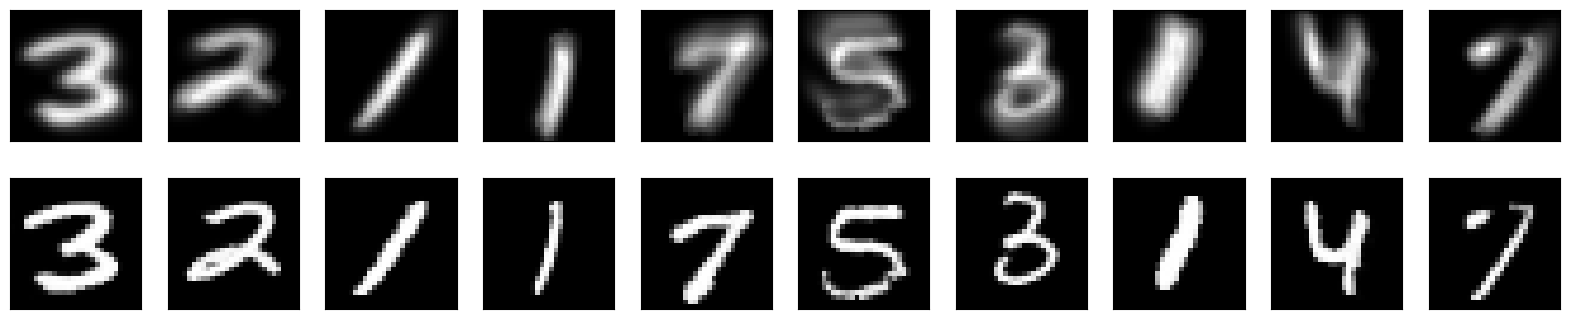

10


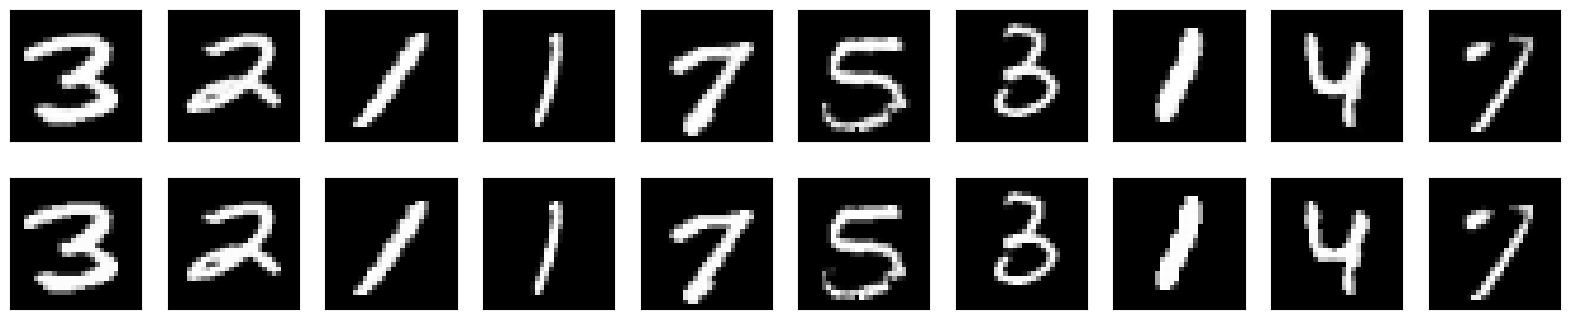

In [ ]:
def plot(x,y):
  no = x.shape[0]
  print(no)
  plt.figure(figsize=(2*no, 4))
  for i in range(no):
    # display original
    ax = plt.subplot(2, no, i + 1)
    plt.imshow(x[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, no, i + 1 + no)
    plt.imshow(y[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

mse_values = []
for i in range(10):
    blurred_images, ground_truth_images = next(generator(x_valid, 10000))
    deblurred_images = model.predict(blurred_images)
    deblurred_images = np.squeeze(deblurred_images)
    mse = np.mean((deblurred_images - ground_truth_images)**2)
    mse_values.append(mse)

mse_mean = np.mean(mse_values)
mse_std = np.std(mse_values)

print(f'MSE Mean: {mse_mean}, MSE Std: {mse_std}')

blurred_images, ground_truth_images = next(generator(x_valid, 10))
deblurred_images = model.predict(blurred_images).squeeze()

plot(blurred_images, deblurred_images)
plot(deblurred_images, ground_truth_images)




Nel primo grafico viene mostrato il confronto tra le immagini con blur e le immagini predette dal mio modello. Nel secondo il confronto tra le immagini predette dal mio modello e le immagini di partenza senza blur.

# **Discussione scelte**
Ho scelto di utilizzare un modello di rete neurale convoluzionale (CNN) per il deblurring delle immagini dato che le CNN sono particolarmente efficaci nel riconoscere i pattern visivi nelle immagini. Il modello utilizza blocchi ResNet, che sono efficaci nel gestire il problema del vanishing gradient, e permettono al modello di apprendere da un numero maggiore di layer senza perdere informazioni importanti.

Ho utilizzato la funzione di attivazione ReLU nei blocchi ResNet perché è computazionalmente efficiente e aiuta a mitigare il problema del vanishing gradient. Inoltre, ho utilizzato la normalizzazione batch per rendere il modello più stabile e veloce durante l’addestramento.

Infine, ho scelto di utilizzare  l’ottimizzatore Adam con un learning rate di 0.0002 e beta_1 di 0.5.

#**Discussione scelta iper-paramtri**
***Numero di blocchi ResNet (num_resnet_blocks=9):*** Questo numero è stato scelto in base a vari esperimenti per trovare un equilibrio tra la complessità del modello e la sua capacità di apprendere pattern complessi nelle immagini.

***Dimensione del kernel (kernel_size=(3,3)):***  Questa è una dimensione comune del kernel utilizzata nelle CNN perché è abbastanza grande da catturare i pattern spaziali nelle immagini, ma abbastanza piccola da mantenere la complessità del modello gestibile.

***Numero di filtri (filters=64):***  Questo numero è stato scelto per permettere al modello di apprendere una varietà di pattern visivi senza aumentare eccessivamente la complessità del modello.

***Dimensione del batch (batchsize=64):***  Questa dimensione è stata scelta per bilanciare l’efficienza computazionale (i batch più grandi possono essere processati più velocemente su GPU) con la qualità dell’apprendimento (i batch più piccoli possono a volte portare a un apprendimento più stabile).

***Numero di epoche (epochs=99):*** Questo numero è stato scelto per dare al modello abbastanza tempo per apprendere i pattern nelle immagini senza rischiare di sovradattamento e per rientrare nei limiti di Colab.

***Learning rate (lr=0.0002):*** Questo valore è stato scelto perché è abbastanza piccolo da permettere un apprendimento stabile, ma abbastanza grande da permettere un progresso significativo in ogni epoca.

***Beta_1 (beta_1=0.5):***  Questo valore è stato scelto perché controlla la decadenza del momento del gradiente, e un valore di 0.5 è spesso utilizzato come default in molte implementazioni di Adam.
